In [1]:
from __future__ import division
from astropy.io import fits
import glob
import copy
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import special as sp
from ipykernel import kernelapp as app

l_w = [3610.51,3650.15,4046.56,4358.33,4678.16,4799.92,5085.82,5460.74,5769.59,5790.65,5875.62]
l_l = ['Cd I', 'Hg I', 'Hg I','Hg I', 'Cd I' , 'Cd I', 'Cd I', 'Hg I', 'Hg I', 'Hg I', 'He']

In [2]:
bias_list = glob.glob('Project_3_data/BIAS/*.fits')
flat_list = glob.glob('Project_3_data/FLAT/*.fits')
arc_list = glob.glob('Project_3_data/arc/*.fits')
UGC_list = glob.glob('Project_3_data/UGC7321/*.fits')
IC_list = glob.glob('Project_3_data/IC4202/*.fits')

In [3]:
#define a functioon that saves the fits
def write_hdulist_to(hdulist, fileobj, overwrite= True, **kwargs):
    hdulist.writeto(fileobj, overwrite = True, **kwargs)

### Master Bias

In [4]:
#Define a zero array
master_bias = np.zeros(fits.getdata(bias_list[0]).shape)

#Get master bias(mean)
for i in range(len(bias_list)):
    master_bias += fits.getdata(bias_list[i])

master_bias /= len(bias_list)
#cut the over scanned area
m_bias = master_bias[80:2650,112:400]

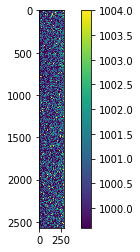

In [5]:
plt.imshow(m_bias,vmin = np.percentile(master_bias,16),vmax = np.percentile(master_bias,84))
plt.colorbar()

### Master Flat

In [6]:
#Define a zero array for flat
m_flat = np.zeros((m_bias.shape[0],m_bias.shape[1],len(flat_list)))

#Get master flat and normalize
for i in range(len(flat_list)):
    hdr_f = fits.getdata(flat_list[i])
    hdr_f = hdr_f[80:2650,112:400]
    m_flat[:,:,i] = (hdr_f - m_bias)
    
    
print('shape of flat series',m_flat.shape)
m_flat = np.mean(m_flat, axis = 2)
m_flat /= np.mean(m_flat)

shape of flat series (2570, 288, 5)


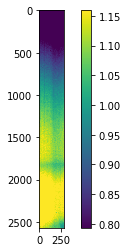

In [7]:
plt.imshow(m_flat,vmin = np.percentile(m_flat,16),vmax = np.percentile(m_flat,84))
plt.colorbar()

### Calibrate for arc

In [8]:
m_arc = np.zeros((m_bias.shape[0],m_bias.shape[1],len(arc_list))) 

for i in range(len(arc_list)):
    hdu_arc = fits.open(arc_list[i],mode='update')
    hdu_arcdata = hdu_arc[0].data
    hdu_archdr = hdu_arc[0].header
    obs_num = hdu_archdr['OBSNUM']
    #define names for the files
    uni_ID = 'arc'+'_'+str(obs_num)
    #chop the images
    hdu_arcdata = hdu_arcdata[80:2650,112:400]
    #do the data reducation
    m_arc[:,:,i] = (hdu_arcdata - m_bias)
    arc = np.divide(m_arc[:,:,i], m_flat, out=np.zeros_like(m_arc[:,:,i]), where=m_flat!=0)
    #save every image
    outhdu = fits.PrimaryHDU(data = arc, header = hdu_archdr)
    write_hdulist_to(outhdu, 'Project_3_data/arc/Reduced_arc/{}.fits'.format(uni_ID))

In [9]:
#open the reduced arc and stack
red_arc_list = glob.glob('Project_3_data/arc/Reduced_arc/*.fits')

#make an array of images from the list of images
arc_concat = [fits.getdata(image) for image in red_arc_list] 

#stack the images together with mean
stacked_arc = np.mean(arc_concat, axis=0)

### Use arc and spectrum image to calibrate for wavelength

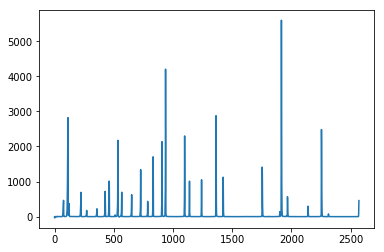

In [10]:
arc2D = stacked_arc
arc1D = np.mean(arc2D,axis=1)

arc1D_list = list(arc1D)
list1 = list(arc1D)
list1.sort()

plt.plot(arc1D)

In [11]:
# set up calibration points

length = len(list1) 
cali1 = arc1D_list.index(list1[length-1])
cali2 = arc1D_list.index(list1[length-3])
cali3 = arc1D_list.index(list1[length-5])
cali4 = arc1D_list.index(list1[length-8])
cali5 = arc1D_list.index(list1[length-10])
cali6 = arc1D_list.index(list1[length-12])

cali7 = arc1D_list.index(list1[length-13])
cali8 = arc1D_list.index(list1[length-18])
cali9 = arc1D_list.index(list1[length-22])


or1 = 7032.413 #
or2 = 6402.246 #
or3 = 6678.276 #
or4 = 7245.167 #
or5 = 6506.528 #
or6 = 6143.062 #

or7 = 6382.991 #
or8 = 6334.428 # 
or9 = 6929.468 # 

x = np.array([cali1, cali2, cali3, cali4, cali5,
              cali6,cali7, cali8, cali9])
y = np.array([or1, or2, or3, or4, or5,or6,
             or7,or8,or9])
print(x)

[1915  937 1363 2253 1098  535  907  832 1753]


calibration parameteres 0.6428146133864798 5800.269909667837


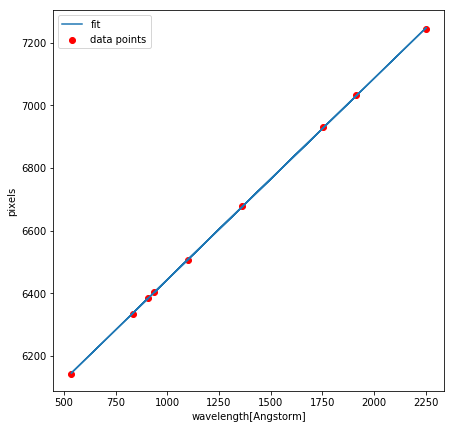

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(x,y,c='r',label='data points')

a_fit, b_fit = np.poly1d(np.polyfit(x, y, 1)) #weight with uncertainties
print('calibration parameteres',a_fit, b_fit)

y_fit = a_fit *x + b_fit
plt.plot(x,y_fit,label='fit')
plt.xlabel('wavelength[Angstorm]')
plt.ylabel('pixels')
plt.legend()
plt.savefig('Pix2wavelength.png')

### UGC7321(Deserted)

In [ ]:
# calibration
cali_UGC = np.zeros((m_bias.shape[0],m_bias.shape[1],len(UGC_list))) 

for i in range(len(UGC_list)):
    hdu_UGC = fits.open(UGC_list[i],mode='update')
    hdu_UGCdata = hdu_UGC[0].data
    hdu_UGChdr = hdu_UGC[0].header
    obs_num = hdu_UGChdr['OBSNUM']
    #define names for the files
    uni_ID = 'UGC'+'_'+str(obs_num)
    #chop the images
    hdu_UGCdata = hdu_UGCdata[80:2650,112:400]
    #do the data reducation
    cali_UGC[:,:,i] = (hdu_UGCdata - m_bias)
    UGC = np.divide(cali_UGC[:,:,i], m_flat, out=np.zeros_like(cali_UGC[:,:,i]), where=m_flat!=0)
    swapedUGC = np.swapaxes(UGC, 0, 1)
    #save every image
    outhdu = fits.PrimaryHDU(data = swapedUGC, header = hdu_UGChdr)
    write_hdulist_to(outhdu, 'Project_3_data/UGC7321/ReducedUGC/{}.fits'.format(uni_ID))

In [ ]:
data1 = fits.open( 'Project_3_data/UGC7321/ReducedUGC/UGC_1171.fits')[0].data
data2 = fits.open( 'Project_3_data/UGC7321/ReducedUGC/UGC_1173.fits')[0].data
data3 = fits.open( 'Project_3_data/UGC7321/ReducedUGC/UGC_1174.fits')[0].data
data4 = fits.open( 'Project_3_data/UGC7321/ReducedUGC/UGC_1175.fits')[0].data

stacked_UGC = np.zeros(data1.shape)

for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        a= data1[i,j]
        b= data2[i,j]
        c= data3[i,j]
        d= data4[i,j]
        stacked_UGC[i,j] = (sum([a,b,c,d])-max(a,b,c,d))/3

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(stacked_UGC,vmin = np.percentile(stacked_UGC,5),vmax = np.percentile(stacked_UGC,95),origin='lower')

In [ ]:
UGC_1D = np.mean(stacked_UGC,axis=0)
#UGC_a = np.mean(UGC2D[130:150],axis=0)
#UGC_b = np.mean(UGC2D[150:170],axis=0)

UGC_a = stacked_UGC[20]
UGC_b = stacked_UGC[100]
UGC_c = stacked_UGC[200]
UGC_d = stacked_UGC[289]


gauss_kernel = Gaussian1DKernel(3)
UGC_1D_sm = convolve(UGC_1D, gauss_kernel)



pixel = np.linspace(1,len(UGC_1D),len(UGC_1D))
cali = a_fit*pixel+b_fit

plt.plot(cali,UGC_a-20,c='y')
plt.plot(cali,UGC_b,c='g')
plt.plot(cali,UGC_c+20,c='b')
plt.plot(cali,UGC_d+40,c='black')
plt.xlim(6560,6580)
plt.ylim(-5,100)

z = 0.00136
z_x = 6563*(z+1)

plt.axvline(z_x,c='r',alpha=0.3)

In [ ]:
trail_wave_list = []
spec2D = stacked_UGC
for i in range(len(spec2D)):
    
    # 2D-> 1D
    spec_1D = spec2D[i]
    
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(3)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    
    # Truncation 1D to 1200.432837497146
    spec_1D_trunc = spec_1D_sm[1180:1220]
    
    # Build new list to include the "Sum of each 5 element" as gaussian sum
    sum_spec_1D = []
    for i in range(len(spec_1D_trunc)):
        sum_1D_value = sum(spec_1D_trunc[i-3:i+3])
        sum_spec_1D.append(sum_1D_value)
    
    sorted_L = list(sum_spec_1D)
    sorted_L.sort()
    length = len(sorted_L)
    h_alpha = sorted_L[length-4]
    
    x_pixel_index = list(sum_spec_1D).index(h_alpha)
    trail_wave_list.append(x_pixel_index)
    
plt.scatter(np.linspace(1,300,300),trail_wave_list,s=3)
plt.axhline(20,c='r',alpha=0.3)
plt.ylim(10,30)

In [ ]:
wave_list = []
for i in range(len(stacked_UGC)):
    # 2D-> 1D
    UGC_1D = stacked_UGC[i]
    # find value of the brightest pixel
    h_alpha = max(UGC_1D[1190:1205])
    # find position of the pixel
    wave_ele = list(UGC_1D[1190:1205]).index(h_alpha)
    # create list
    wave_list.append(wave_ele)

In [ ]:
#0.43*arcsec
#110.66*Mpc

pix2ly = np.deg2rad(0.43/3600)*0.43*3261563.7967311

wave = []
velocity = []

for i in wave_list:
    obs = (int(i)+1406)*a_fit+b_fit
    z = (obs-6562.)/6562.8
    v = z*299792.458
    wave.append(obs)
    velocity.append(v)
    
pixel = np.linspace(1,300,300)
plt.scatter(velocity,pixel*pix2ly,s=1)
#plt.xlim(85,120)
#plt.ylim(80,150)

### IC4202

In [17]:
# calibration
cali_IC = np.zeros((m_bias.shape[0],m_bias.shape[1],len(IC_list))) 

for i in range(len(IC_list)):
    hdu_IC = fits.open(IC_list[i],mode='update')
    hdu_ICdata = hdu_IC[0].data
    hdu_IChdr = hdu_IC[0].header
    obs_num = hdu_IChdr['OBSNUM']
    #define names for the files
    uni_ID = 'IC'+'_'+str(obs_num)
    #chop the images
    hdu_ICdata = hdu_ICdata[80:2650,112:400]
    #do the data reducation
    cali_IC[:,:,i] = (hdu_ICdata - m_bias)
    IC = np.divide(cali_IC[:,:,i], m_flat, out=np.zeros_like(cali_IC[:,:,i]), where=m_flat!=0)
    swapedIC = np.swapaxes(IC, 0, 1)
    #save every image
    outhdu = fits.PrimaryHDU(data = swapedIC, header = hdu_IChdr)
    write_hdulist_to(outhdu, 'Project_3_data/IC4202/ReducedIC/{}.fits'.format(uni_ID))

In [18]:
# substract the cosmic rays by comparing two frames
# the stacking process is done at the same time
dataIC1 = fits.open( 'Project_3_data/IC4202/ReducedIC/IC_1169.fits')[0].data
dataIC2 = fits.open('Project_3_data/IC4202/ReducedIC/IC_1170.fits')[0].data

stacked_IC = np.zeros(dataIC1.shape)

for i in range(dataIC1.shape[0]):
    for j in range(dataIC1.shape[1]):
        a= dataIC1[i,j]
        b= dataIC2[i,j]
        stacked_IC[i,j] = (sum([a,b])-max(a,b))

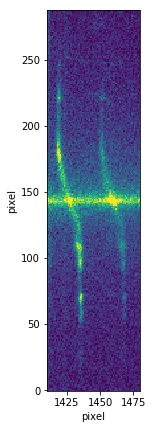

In [19]:
#the stacked frame
plt.figure(figsize=(7,7))
plt.imshow(stacked_IC,vmin = np.percentile(stacked_IC,5),vmax = np.percentile(stacked_IC,95),origin='lower')
plt.xlim(1410,1480)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.savefig('spectrum.png')

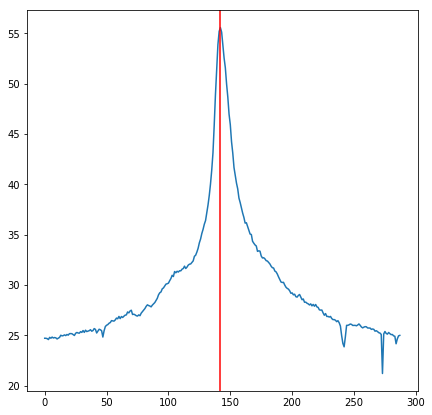

In [20]:
#find the center of galaxy by collasping it in the x-axis direction
#the peak with greatest pixel value would be the center
plt.figure(figsize=(7,7))
oneD = np.mean(stacked_IC,axis=1)
plt.plot(oneD)
plt.axvline(142,c='r')

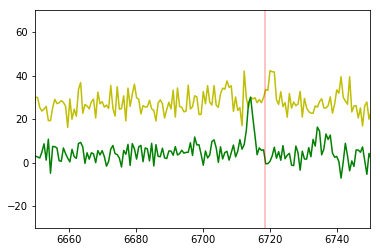

In [21]:
#plot some rows and the H-a line
#determine the region for H-a emission peak

#extract the wave length axis
IC1D = np.mean(stacked_IC,axis=0)

#define two rows
IC_a = stacked_IC[130]
IC_b = stacked_IC[170]

#define x-axis and set cali for pix2wavelength
pix = np.linspace(1,len(IC1D),len(IC1D))
cali = a_fit*pix+b_fit

#plot and compare
plt.plot(cali,IC_a,c='y')
plt.plot(cali,IC_b-20,c='g')
plt.xlim(6650,6750)
plt.ylim(-30,70)

#plot the red-shifted H-a line(red line)
z = 0.0237
z_x = 6563*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)

In [22]:
#chop the frame and pick the max value by comparing the mean of a group of five pixels
    
trail_wave_list = []
trail_std_list = []
trail_mean_list = []
for i in range(len(stacked_IC)):
    
    # 2D-> 1D
    spec_1D = stacked_IC[i]
    
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(2)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    
    # Truncation 1D to 1410~1450
    spec_1D_trunc = spec_1D_sm[1410:1440]
    
    # Build new list to include the "mean of each 5 element(in every row)" as gaussian sum
    mean_spec_1D = []
    for j in range(len(spec_1D_trunc)):
        mean_1D_value = sum(spec_1D_trunc[j-2:j+2])/5
        mean_spec_1D.append(mean_1D_value)
    
    h_alpha = max(mean_spec_1D)
    
    #Write the max means of every row into a new list, also caculate the std of 7 elements near the picked mean
    xp_i = list(mean_spec_1D).index(h_alpha)
    trail_std = np.std(spec_1D_trunc[xp_i-3:xp_i+3])
    
    trail_wave_list.append(xp_i)
    trail_std_list.append(trail_std)

D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

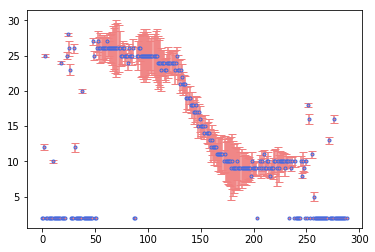

In [23]:
plt.errorbar(np.linspace(0,288,288),trail_wave_list,yerr=trail_std_list,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

In [24]:
# inverse/reverse axis, combines radius


# for x-position:
ICWL_m = 18

# center at 142
ICWL_1 = trail_wave_list[50:142]
ICWL_2 = trail_wave_list[142:234]

ICWL_1G = list(np.flip(ICWL_1))
ICWL_2G = []

for i in ICWL_2:
    new_i = 2*ICWL_m-i
    ICWL_2G.append(new_i)
    
ICWL = [None]*(len(ICWL_1G)+len(ICWL_2G))
ICWL[::2] = ICWL_1G
ICWL[1::2] = ICWL_2G



# for STD:

ICWL_std_1 = trail_std_list[50:142]
ICWL_std_2 = trail_std_list[142:234]

ICWL_std = [None]*(len(ICWL_std_1)+len(ICWL_std_2))
ICWL_std[::2] = ICWL_std_1
ICWL_std[1::2] = ICWL_std_2


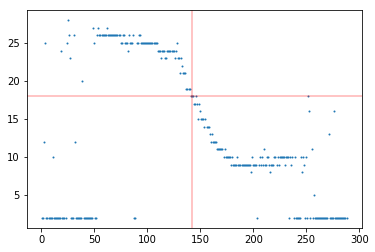

In [25]:
#the plotted line indicates the center of galaxy
pixel = np.linspace(1,288,288)
plt.scatter(pixel,trail_wave_list,s=1)
#plt.xlim(50,272)
#plt.ylim(10,35)
plt.axhline(18,c='r',alpha=0.3)
plt.axvline(142,c='r',alpha=0.3)

### Exclude the points picked but not on the H-a line

In [26]:
def reject_outlier(L,n=3):
    new_list = []
    for i in range(len(L)):
        if np.std(L[i-1:i+1])>=n:
            j = sum(L[i+1:i-1])/2
            new_list.append(j)
        else:
            new_list.append(L[i])
    return new_list

def zero_elm(L):
    new_list = []
    for i in range(len(L)):
        if L[i] == 0:
            j = np.mean(L)
            new_list.append(j)
        else:
            new_list.append(L[i])
    return new_list
            
        
ICWL = reject_outlier(ICWL)

D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

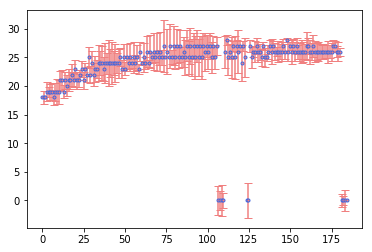

In [27]:
#the graph shows the value of outed points became zero
len(ICWL)
plt.errorbar(np.linspace(0,184,184),ICWL,yerr=ICWL_std,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

### Do 7x10 binning for error bar

In [28]:
# Yield successive n-sized 
# chunks from l. 
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
#divide the list into chunks of 10 elements
#caculate the mean and std

#propogate the error of 5 pixs on a row into 5x10 pix array error
#function is sqrt(sum((sigma_n)^2) where n = 10

def extract_error(L):
    d = 0
    for i in L:
        if np.isnan(i)==True:
            pass
        else:
            sq_i = i**2
            d = d+sq_i
    return np.sqrt(d)/(len(~np.isnan(L)))

#for every 10 pix find mean
#for the outed points that are setted to zero value, ignore

def extract_data(L):
    d = 0
    for i in L:
        d = d+i
    return d/np.count_nonzero(L)


#chop again and divide into chunks of 10
ICWL_div = np.array(list(divide_chunks(ICWL[0:180], 10)) )
ICWL_std_div = np.array(list(divide_chunks(ICWL_std[0:180], 10)) )


# find mean and error for 5x10 pixel array
ICdata = []
ICerr = []

for i in range(len(ICWL_div)):
    new_data = extract_data(ICWL_div[i])
    ICdata.append(new_data)
    
for i in range(len(ICWL_std_div)):
    new_error = extract_error(ICWL_std_div[i])
    ICerr.append(new_error)

<ErrorbarContainer object of 3 artists>

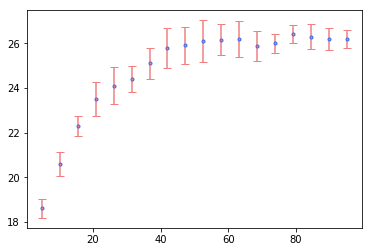

In [33]:
pixel = np.linspace(5,95,len(ICdata))
plt.errorbar(pixel,ICdata,yerr=ICerr,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

### Propagate error and transfer pixel to km/s and kpc

In [34]:
#0.43*arcsec
#110.66*Mpc

#define x-axis transfer function
pix2kpc = np.deg2rad(0.43/3600)*110660

ICr = []
ICv = []
ICverr = []

#transfer x-axis into kpc
for i in pixel:
    new_i = i*pix2kpc
    ICr.append(new_i)
    
#transfer y-axis into km/s
for i in ICdata:
    obs = (i+1405+161)*a_fit+b_fit
    z = (obs-6562.8)/6562.8
    v = (z-0.0238)*299792.458-4480
    ICv.append(v)

#propagate error
for i in ICerr:
    new_i = i*299792.458*0.64281/6562.8
    ICverr.append(new_i)

### IC4202 Model

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


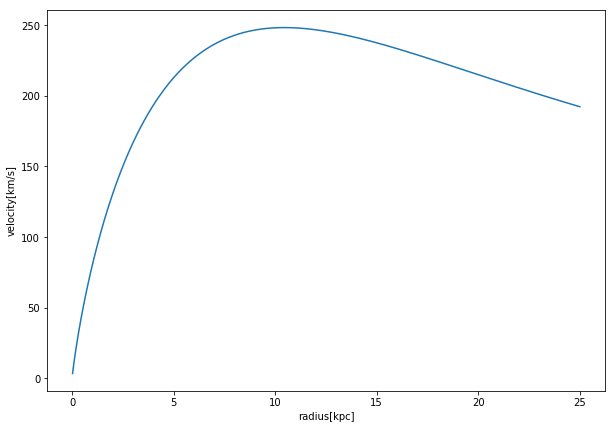

In [35]:
def V_SQ_R(R):
    G = 4.302e-6 #m3 kg-1 s-2
    
    m_stellar = 180e9 #solar mass
    Rd = 4.86 #kpc
    sigma_0 = m_stellar/(2*np.pi*Rd**2)
    y = R/(2*Rd)
    
    I0 = sp.iv(0,y)
    I1 = sp.iv(1,y)
    
    K0 = sp.kv(0,y)
    K1 = sp.kv(1,y)

    V2 = 4*np.pi*G*sigma_0*Rd*(y**2)*(I0*K0-I1*K1)
    v = np.sqrt(V2)
    return v

model_v = []
#r_max is the radius in kpc
r_max = 25

for i in np.linspace(0,r_max,1000):
    modelv = V_SQ_R(i)
    model_v.append(modelv)
    
    
# now model_v is the set of model velocity

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0,r_max,1000),model_v)

plt.xlabel('radius[kpc]')
plt.ylabel('velocity[km/s]')
plt.savefig('model.png')

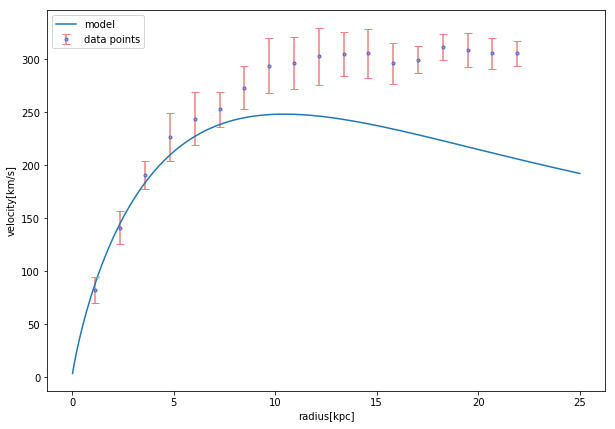

In [36]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(0,r_max,1000),model_v,label="model")
plt.errorbar(ICr,ICv,yerr=ICverr,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

plt.xlabel('radius[kpc]')
plt.ylabel('velocity[km/s]')
plt.legend()
plt.savefig('ICdata.png')